In [3]:
import scanpy as sc

from scprint import scPrint
from scprint.tasks import Embedder

from scdataloader import Preprocessor
from scdataloader.utils import load_genes, translate

import numpy as np
import pandas as pd

from scib_metrics.benchmark import Benchmarker

import matplotlib.pyplot as plt

from collections import Counter

%load_ext autoreload
%autoreload 2

import torch
torch.set_float32_matmul_precision('medium')


💡 lamindb instance: jkobject/scprint


## preparing the model

In [2]:
#model = scPrint.load_from_checkpoint('../../data/tensorboard/scprint_test/urxxwu28/checkpoints/epoch=0-step=20000.ckpt') #chocolate-surf-8
model = scPrint.load_from_checkpoint('../../data/temp/6q3dzi3x/epoch=3-step=10000.ckpt', precpt_gene_emb = '../../data/temp/embeddings.parquet')
# ../../data/temp/epoch=4-step=12500.ckpt latest model maestro (fortuitous laugther)
# ../../data/logs/scprint_test/f4vao230/checkpoints/epoch=10-step=27500.ckpt looked good as a training run (vermlillion noodle)
# d1792z9k/epoch=3-step=10000.ckpt
# '../../data/temp/d1792z9k/epoch=3-step=10000.ckpt'

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/lightning/pytorch/utilities/migration/utils.py:55: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.2.0.post0, which is newer than your current Lightning version: v2.0.9.post0
  rank_zero_warn(


scPrint(
  (gene_encoder): GeneEncoder(
    (embedding): Embedding(33890, 128)
    (enc_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (expr_encoder): ContinuousValueEncoder(
    (encoder): ModuleList(
      (0): Linear(in_features=1, out_features=128, bias=True)
      (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
  )
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (label_encoder): CategoryValueEncoder(
    (embedding): Embedding(8, 128)
    (enc_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (time_encoder): ContinuousValueEncoder(
    (encoder): ModuleList(
      (0): Linear(in_features=1, out_features=128, bias=True)
      (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
  )
  (transformer): FlashTransformerEnc

## Loading the data

In [4]:
#only dataset dropped
adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/z7ZZxORUQFshySbuvNW7.h5ad') 

# one that it trained on: z7ZZxORUQFshySbuvNW7.
# untrained on: BljRloq1xjcxRNDpejzI

In [174]:
adata = sc.read(
    "data/pancreas_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539828",
)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [4]:
adata = sc.read(
    "data/lung_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539942",
)

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [5]:
preprocessor = Preprocessor(subset_hvg=1000, use_layer='counts', is_symbol=True, force_preprocess=True, skip_validate=True, do_postp=False)

In [6]:
adata.obs['organism_ontology_term_id'] = "NCBITaxon:9606"
adata = preprocessor(adata.copy())

Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
Removed 0 genes.
Seeing 10331 outliers (32.03% of total dataset):


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [192]:
sc.pl.umap(adata, color="celltype")

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'organism_ontology_term_id' as categorical
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
... storing 'symbol' as categorical
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
... storing 'ncbi_gene_ids' as categorical
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
... storing 'bioty

KeyError: "Could not find 'umap' or 'X_umap' in .obsm"

In [9]:
translate(adata.obs.assay_ontology_term_id.tolist(), "assay")

AttributeError: 'DataFrameView' object has no attribute 'assay_ontology_term_id'

In [194]:
Counter(adata.obs.cell_type)

Counter({'Macrophage': 7433,
         'Type 2': 4246,
         'Ciliated': 3145,
         'Basal 2': 3072,
         'Secretory': 2433,
         'Basal 1': 1972,
         'T/NK cell': 1771,
         'Neutrophil_CD14_high': 1626,
         'Dendritic cell': 1367,
         'B cell': 1331,
         'Endothelium': 978,
         'Mast cell': 877,
         'Fibroblast': 730,
         'Neutrophils_IL1R2': 472,
         'Type 1': 418,
         'Lymphatic': 334,
         'Ionocytes': 46})

# good dataset

In [8]:
model.pred_embedding

['cell_type_ontology_term_id',
 'disease_ontology_term_id',
 'self_reported_ethnicity_ontology_term_id',
 'sex_ontology_term_id']

In [9]:
model.pred_embedding = ["cell_type_ontology_term_id"]

In [10]:
embed = Embedder(model, output_expression="sample", how="most expr", max_len=1000, add_zero_genes=100)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
sc.pp.highly_variable_genes(adata)

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scipy/sparse/_data.py:148: RuntimeWarning: overflow encountered in expm1
  result = op(self._deduped_data())


ValueError: cannot specify integer `bins` when input data contains infinity

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 32251 × 128
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'leiden'
    uns: 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

couldn't log to tensorboard
couldn't log to wandb
> /home/ml4ig1/Documents code/scPRINT/scprint/tasks/cell_emb.py(125)__call__()
    123 
    124             pdb.set_trace()
--> 125             random_indices = np.random.randint(
    126                 low=0, high=adata.shape[0], size=self.plot_corr_size
    127             )



/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scipy/sparse/_data.py:148: RuntimeWarning: overflow encountered in expm1
  result = op(self._deduped_data())


*** ValueError: cannot specify integer `bins` when input data contains infinity
0.029635437


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


AnnData object with n_obs × n_vars = 32251 × 70116
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', 'organism_ontology_term_id', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'leiden'
    var: 'uid', 'symbol', 'stable_id', 'ncbi_gene_ids', 'biotype', 'description', 'synonyms', 'organism_id', 'public_source_id', 'created_at', 'updated_at', 'created_by_id', 'mt', 'ribo', '

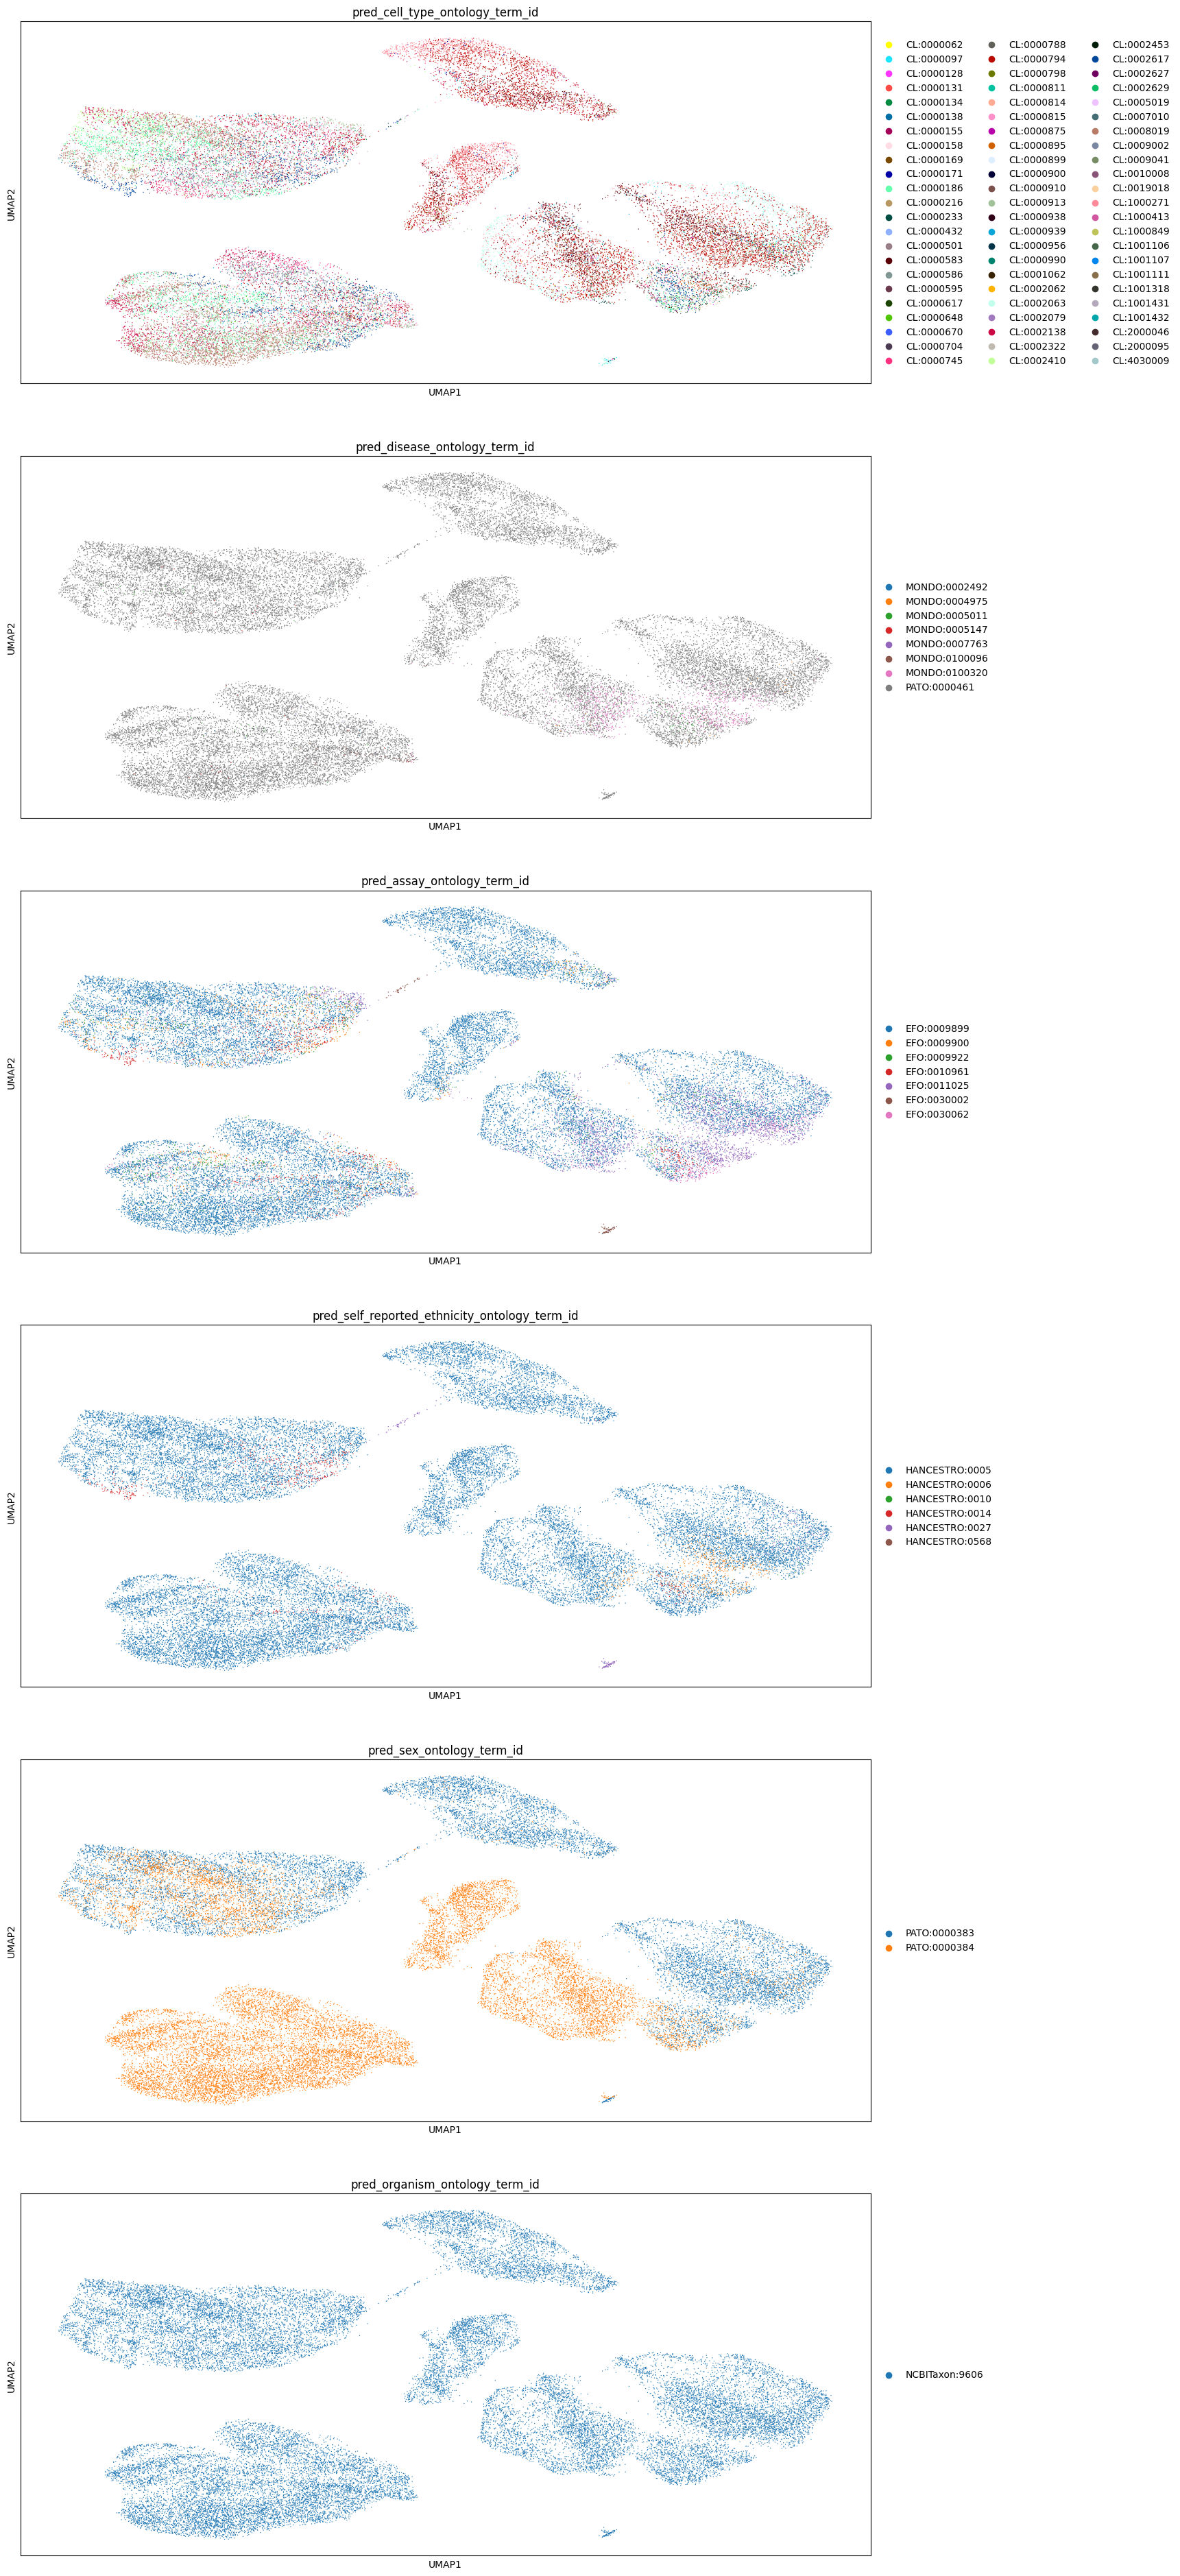

In [13]:
n_adata = embed(adata.copy())

In [199]:
n_adata.obs.loc[n_adata.obs.pred_cell_type_ontology_term_id=="CL:0002063"].cell_type.value_counts()
# pneumocyte: CL:1000271
# type 2 CL:0002063

cell_type
Type 2                  795
B cell                  351
Secretory               107
Macrophage               49
Type 1                   20
Mast cell                17
Endothelium              16
T/NK cell                12
Ciliated                  9
Lymphatic                 3
Basal 2                   1
Dendritic cell            1
Fibroblast                1
Ionocytes                 0
Basal 1                   0
Neutrophil_CD14_high      0
Neutrophils_IL1R2         0
Name: count, dtype: int64

In [201]:
translate(n_adata.obs.loc[n_adata.obs.cell_type=="Secretory"].pred_cell_type_ontology_term_id.value_counts().index)

In [200]:
n_adata.obs.loc[n_adata.obs.cell_type=="Secretory"].pred_cell_type_ontology_term_id.value_counts()

pred_cell_type_ontology_term_id
CL:0000648    1035
CL:0000794     251
CL:0000186     171
CL:0000586     138
CL:0000913     137
CL:0002617     115
CL:0002063     107
CL:0000815      97
CL:0008019      56
CL:1000271      52
CL:0000138      47
CL:0000128      41
CL:0002062      36
CL:0000938      29
CL:1001431      21
CL:0000583      16
CL:0002138      15
CL:0000745      11
CL:0000875       7
CL:0000233       6
CL:1000597       6
CL:0000939       5
CL:0000798       4
CL:0000158       4
CL:1001432       3
CL:0000814       3
CL:0019018       2
CL:0000097       2
CL:0000788       2
CL:0000595       2
CL:0000895       2
CL:0000171       2
CL:1001111       1
CL:0000987       1
CL:1000692       1
CL:0000706       1
CL:0000155       1
CL:0002322       1
CL:0002410       1
CL:0000169       1
CL:1001106       0
CL:0010008       0
CL:1000413       0
CL:1001318       0
CL:0009017       0
CL:0000956       0
CL:0005019       0
CL:0002629       0
CL:0002548       0
CL:0002453       0
CL:0002193       0

In [188]:
n_adata.obs.loc[n_adata.obs.celltype=="alpha"].pred_cell_type_ontology_term_id.value_counts()

pred_cell_type_ontology_term_id
CL:0000171    2003
CL:0000169     934
CL:1000271     745
CL:0000706     572
CL:0000173     456
              ... 
CL:0002064       0
CL:0002241       0
CL:0002258       0
CL:0002470       0
CL:4030009       0
Name: count, Length: 73, dtype: int64

In [67]:
n_adata.obs.loc[n_adata.obs.pred_cell_type_ontology_term_id=="CL:0000622"].celltype.value_counts()

celltype
acinar                0
activated_stellate    0
alpha                 0
beta                  0
delta                 0
ductal                0
endothelial           0
epsilon               0
gamma                 0
macrophage            0
mast                  0
quiescent_stellate    0
schwann               0
t_cell                0
Name: count, dtype: int64

In [16]:
d = translate(n_adata.obs.pred_cell_type_ontology_term_id.tolist())

In [17]:
{d[k]: v for k,v in Counter(n_adata.obs.pred_cell_type_ontology_term_id).items()}

{'cardiac muscle myoblast': 1573,
 'adipocyte of epicardial fat of left ventricle': 612,
 'non-classical monocyte': 198,
 'club cell': 69,
 'plasmablast': 1013,
 'alveolar macrophage': 108,
 'retinal ganglion cell': 3092,
 'kidney collecting duct principal cell': 56,
 'lung neuroendocrine cell': 10,
 'platelet': 152,
 'kidney interstitial fibroblast': 994,
 'type I pneumocyte': 293,
 'lung ciliated cell': 1336,
 'megakaryocyte': 111,
 'retina horizontal cell': 2317,
 'capillary endothelial cell': 101,
 'smooth muscle myoblast': 564,
 'endothelial cell of artery': 57,
 'retinal cone cell': 491,
 'IgA plasma cell': 238,
 'pancreatic A cell': 46,
 'rod bipolar cell': 93,
 'endothelial cell of lymphatic vessel': 75,
 'myofibroblast cell': 9,
 'conventional dendritic cell': 13,
 'podocyte': 984,
 'amacrine cell': 315,
 'Mueller cell': 92,
 'reticulocyte': 77,
 'type II pneumocyte': 6,
 'papillary tips cell': 261,
 'retinal rod cell': 526,
 'kidney loop of Henle thick ascending limb epitheli

In [23]:
n_adata

AnnData object with n_obs × n_vars = 12590 × 70116
    obs: 'hash_label', 'hash_cluster', 'n_genes', 'hashed', 'group', 'treatment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'pct_counts_hb', 'batch', 'S_score', 'G2M_score', 'phase', 'leiden', 'lineage', 'type', 'cds', 'donor_region', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'suspension_type', 'BMI', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'log1p_total_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'outlier', 'mt_outlier', 'leiden

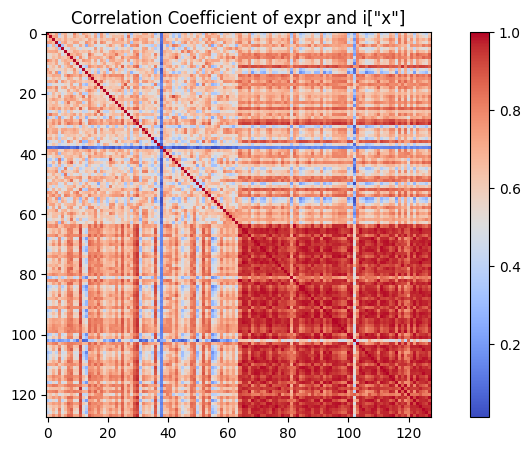

In [72]:
size=64
random_indices = np.random.randint(low=0, high=n_adata.shape[0], size=size)

# Compute correlation coefficient
pos = n_adata.obsm["scprint_pos"][random_indices]
X = n_adata.X[:,n_adata.var.index.isin(embed.model.genes)][random_indices]
corr_coef = np.corrcoef(n_adata.obsm['scprint_expr'][random_indices].numpy(), X[np.array(list(range(size)))[:,None],pos.numpy()].toarray())[:, :]

# Plot correlation coefficient
plt.figure(figsize=(10, 5))
plt.imshow(corr_coef, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.title('Correlation Coefficient of expr and i["x"]')
plt.show()


In [102]:
hierarchical_labels = [
    "cell_type_ontology_term_id", #1
    # "tissue_ontology_term_id",
    "disease_ontology_term_id", # 2
#    "development_stage_ontology_term_id",
    "assay_ontology_term_id", #3
    'self_reported_ethnicity_ontology_term_id', #4
]
labels_to_pred = hierarchical_labels+[
    'sex_ontology_term_id', #5
    "organism_ontology_term_id", #6
]
all_labels = labels_to_pred+[
    #'dataset_id',
    'cell_culture',
    "heat_diff",
    "total_counts",
    "nnz",
    "dpt_group",
]

datamodule = DataModule(
    collection_name="preprocessed dataset",
    #gene_embeddings=gene_emb,
    all_labels=all_labels,
    hierarchical_labels=hierarchical_labels,
    organisms=["NCBITaxon:9606"],
    how="most expr",
    max_len=1000,
    add_zero_genes=100,
    label_to_weight=labels_to_pred,
    label_to_pred=labels_to_pred,
    batch_size=8,
    num_workers=1,
    validation_split=0.1,
    test_split=0.1)
testfiles = datamodule.setup()

NameError: name 'DataModule' is not defined

In [101]:
n_adata

AnnData object with n_obs × n_vars = 128 × 70116
    obs: 'hash_label', 'hash_cluster', 'n_genes', 'hashed', 'group', 'treatment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'pct_counts_hb', 'batch', 'S_score', 'G2M_score', 'phase', 'leiden', 'lineage', 'type', 'cds', 'donor_region', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'suspension_type', 'BMI', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'log1p_total_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'outlier', 'mt_outlier', 'leiden_3

In [73]:
pred_adata

AnnData object with n_obs × n_vars = 12590 × 128
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'leiden'
    uns: 'leiden', 'neighbors', 'pred_assay_ontology_term_id_colors', 'pred_cell_type_ontology_term_id_colors', 'pred_disease_ontology_term_id_colors', 'pred_organism_ontology_term_id_colors', 'pred_self_reported_ethnicity_ontology_term_id_colors', 'pred_sex_ontology_term_id_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

##  ling

In [13]:
adata.obs.cell_type.value_counts()

Macrophage              7492
Type 2                  4286
Ciliated                3155
Basal 2                 3072
Secretory               2459
Basal 1                 1972
T/NK cell               1797
Neutrophil_CD14_high    1626
Dendritic cell          1367
B cell                  1353
Endothelium              988
Mast cell                889
Fibroblast               733
Neutrophils_IL1R2        472
Type 1                   424
Lymphatic                341
Ionocytes                 46
Name: cell_type, dtype: int64

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2024-02-21 10:06:34,900:INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/lightning/pytorch/loops/prediction_loop.py:234: UserWarning: predict returned None if it was on purpose, ignore this warning...
  self._warning_cache.warn("predict returned None if it was on purpose, ignore this warning...")
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 32472 × 128
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'leiden'
    uns: 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data f

couldn't log to tensorboard
couldn't log to wandb


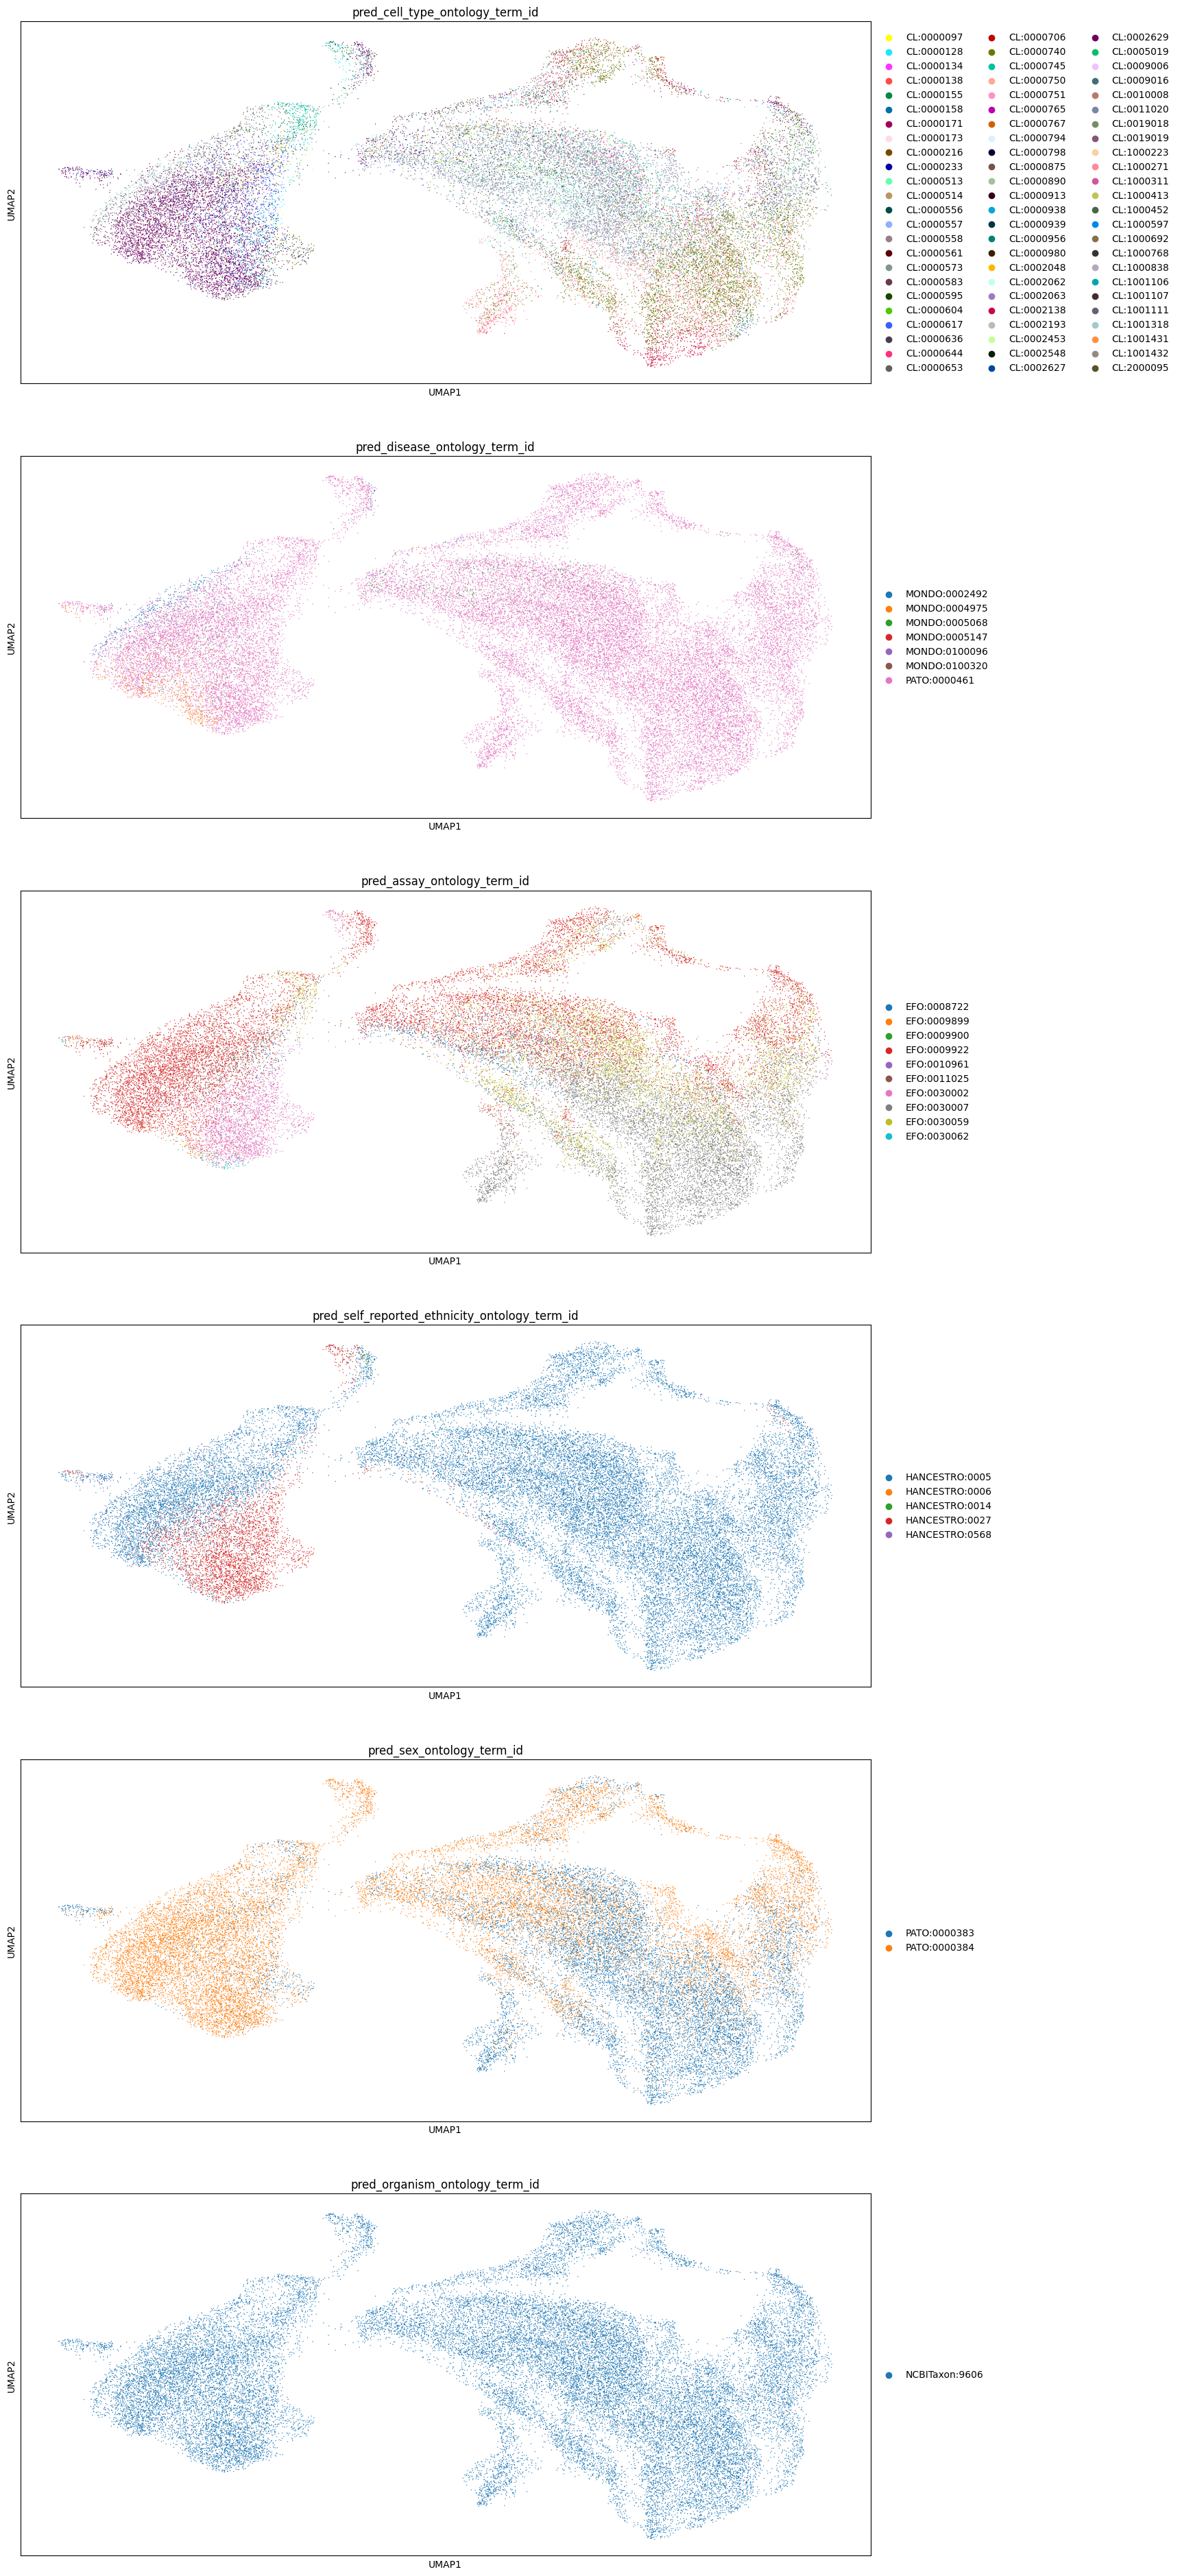

In [15]:
predictions = trainer.predict(model, dataloader)

In [19]:
pred_adata = sc.read_h5ad(
    (model.logger.save_dir if model.logger is not None else ".")
    + "/step_"
    + str(model.global_step)
    + "_umap_"
    + ".h5ad"
)

In [16]:
pred_adata.obs

pred_cell_type_ontology_term_id pred_disease_ontology_term_id  \
0                          CL:0000171                  PATO:0000461   
1                          CL:0000765                  PATO:0000461   
2                          CL:0000171                  PATO:0000461   
3                          CL:0000155                  PATO:0000461   
4                          CL:1000271                  PATO:0000461   
...                               ...                           ...   
10011                      CL:0000155                  PATO:0000461   
10012                      CL:1000343                  PATO:0000461   
10013                      CL:0002064                  PATO:0000461   
10014                      CL:0002064                  PATO:0000461   
10015                      CL:0002064                  PATO:0000461   

      pred_assay_ontology_term_id  \
0                     EFO:0030002   
1                     EFO:0030002   
2                     EFO:0009899   
3                     EFO:0030002   
4                     EFO:0011025   
...                           ...   
10011                 EFO:0030002   
10012                 EFO:0009899   
10013                 EFO:0009899   
10014                 EFO:0009899   
10015                 EFO:0030002   

      pred_self_reported_ethnicity_ontology_term_id pred_sex_ontology_term_id  \
0                                    HANCESTRO:0027              PATO:0000383   
1                                    HANCESTRO:0027              PATO:0000384   
2                                    HANCESTRO:0005              PATO:0000384   
3                                    HANCESTRO:0027              PATO:0000384   
4                                    HANCESTRO:0027              PATO:0000383   
...                                             ...                       ...   
10011                                HANCESTRO:0027              PATO:0000383   
10012                                HANCESTRO:0005              PATO:0000384   
10013                                HANCESTRO:0005              PATO:0000384   
10014                                HANCESTRO:0005              PATO:0000384   
10015                                HANCESTRO:0027              PATO:0000384   

      pred_organism_ontology_term_id leiden  
0                     NCBITaxon:9606     13  
1                     NCBITaxon:9606      1  
2                     NCBITaxon:9606      1  
3                     NCBITaxon:9606      1  
4                     NCBITaxon:9606      6  
...                              ...    ...  
10011                 NCBITaxon:9606      0  
10012                 NCBITaxon:9606     15  
10013                 NCBITaxon:9606     15  
10014                 NCBITaxon:9606     15  
10015                 NCBITaxon:9606     15  

[10016 rows x 7 columns]

In [67]:
expr = np.array(model.expr_pred[0])

In [55]:
model.expr_pred[0]

tensor([[ 3.3980,  2.3354,  1.5864,  ...,  0.0273,  0.1444,  0.0305],
        [ 8.9362, 10.7371,  6.3243,  ...,  0.0356,  0.0299,  0.0267],
        [ 6.4900,  7.1557,  3.1200,  ...,  0.0237,  0.2526,  0.0380],
        ...,
        [ 1.1838,  1.5945,  1.2357,  ...,  0.1673,  5.7084,  0.7229],
        [ 2.3342,  1.6995,  1.4451,  ...,  4.6061,  3.6687,  1.4895],
        [ 1.9409,  1.2229,  1.3898,  ...,  0.4948,  0.5325,  0.4198]])

In [26]:
expr = np.array(model.expr_pred[0])

expr[np.random.binomial(1, p=np.array(torch.nn.functional.sigmoid(model.expr_pred[2].to(torch.float32)))).astype(bool)] = 0

expr[expr<=0.1] = 0
#expr[(expr<=1) & (expr>0.5)] = 1

In [27]:
for i in dataloader:
    print(i["x"].shape)
    break

torch.Size([64, 2200])



In [28]:
size = 64

In [29]:
expr[:size].mean(), expr[:size].max(), (expr[:size]==0).sum()

(0.24403553, 49.77909, 88475)

In [30]:
i['x'].mean(), i['x'].max(), (i['x']==0).sum()

(tensor(0.3969), tensor(447.), tensor(109190))

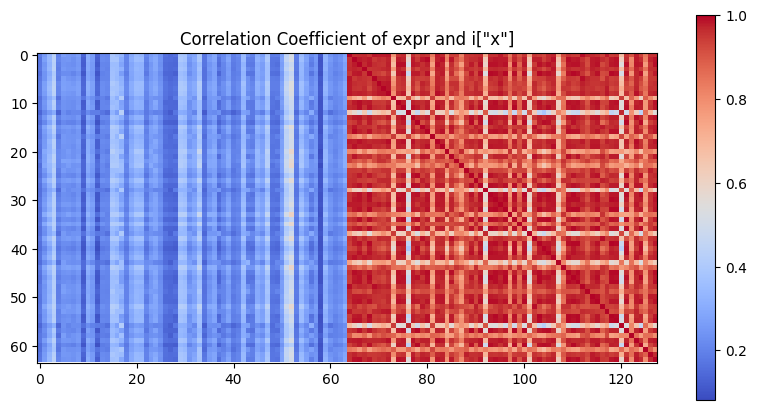

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Compute correlation coefficient
corr_coef = np.corrcoef(expr[:size], i['x'])[size:, :]

# Plot correlation coefficient
plt.figure(figsize=(10, 5))
plt.imshow(corr_coef, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.title('Correlation Coefficient of expr and i["x"]')
plt.show()

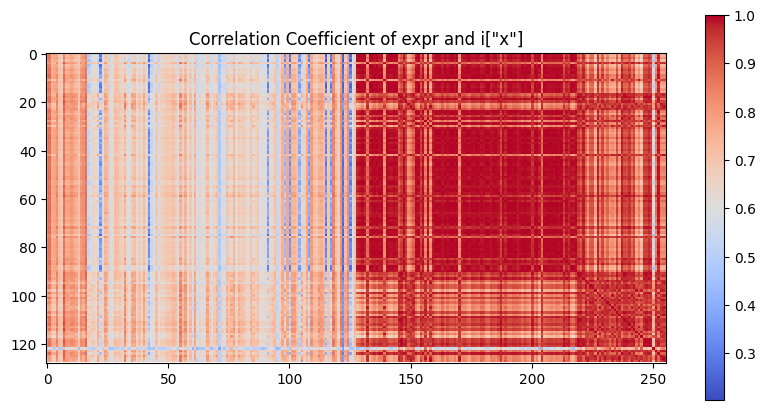

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Compute correlation coefficient
corr_coef = np.corrcoef(expr[:size], i['x'])[size:, :]

# Plot correlation coefficient
plt.figure(figsize=(10, 5))
plt.imshow(corr_coef, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.title('Correlation Coefficient of expr and i["x"]')
plt.show()


In [20]:
pred_adata

AnnData object with n_obs × n_vars = 32472 × 128
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'leiden'
    uns: 'leiden', 'neighbors', 'pred_assay_ontology_term_id_colors', 'pred_cell_type_ontology_term_id_colors', 'pred_disease_ontology_term_id_colors', 'pred_organism_ontology_term_id_colors', 'pred_self_reported_ethnicity_ontology_term_id_colors', 'pred_sex_ontology_term_id_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [21]:
adata

AnnData object with n_obs × n_vars = 32472 × 70116
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', 'organism_ontology_term_id'
    var: 'uid', 'symbol', 'stable_id', 'ncbi_gene_ids', 'biotype', 'description', 'synonyms', 'organism_id', 'public_source_id', 'created_at', 'updated_at', 'created_by_id', 'mt', 'ribo', 'hb', 'organism'
    uns: 'unseen_genes'

In [22]:
subadata = adata

In [23]:
sc.pp.pca(subadata)

In [24]:
pred_adata.obs.index = subadata.obs.index
subadata.obsm["Unintegrated"] = subadata.obsm["X_pca"]
subadata.obsm["X_umap"] = pred_adata.obsm["X_umap"]
subadata.obsm["scprint"] = pred_adata.X
pred_adata.obs.index = subadata.obs.index
subadata.obs = pd.concat([subadata.obs, pred_adata.obs], axis=1)


In [25]:
subadata.obs.loc[subadata.obs.pred_assay_ontology_term_id=="EFO:0008722"].protocol.value_counts()

10x v2      1035
drop-seq     173
Name: protocol, dtype: int64

In [ ]:
subadata.obs.loc[subadata.obs.pred_cell_type_ontology_term_id=="CL:0000171"].cell_type.value_counts()

In [81]:
subadata.obs.loc[subadata.obs.pred_cell_type_ontology_term_id=="CL:0000171"].celltype.value_counts() #type A

alpha                 210
beta                  169
acinar                 41
gamma                  22
ductal                 21
delta                  18
macrophage              2
activated_stellate      1
epsilon                 1
quiescent_stellate      1
endothelial             0
mast                    0
schwann                 0
t_cell                  0
Name: celltype, dtype: int64

In [33]:
subadata.obs.loc[subadata.obs.pred_cell_type_ontology_term_id=="CL:0000171"].celltype.value_counts() #type A

alpha                 221
beta                  164
ductal                 84
acinar                 26
gamma                  23
endothelial            16
delta                  12
quiescent_stellate      5
activated_stellate      4
macrophage              3
epsilon                 2
mast                    0
schwann                 0
t_cell                  0
Name: celltype, dtype: int64

In [82]:
subadata.obs.loc[subadata.obs.pred_cell_type_ontology_term_id=="CL:0000169"].celltype.value_counts() #typeB

beta                  23
delta                  5
acinar                 3
alpha                  2
activated_stellate     0
ductal                 0
endothelial            0
epsilon                0
gamma                  0
macrophage             0
mast                   0
quiescent_stellate     0
schwann                0
t_cell                 0
Name: celltype, dtype: int64

In [34]:
subadata.obs.loc[subadata.obs.pred_cell_type_ontology_term_id=="CL:0000235"].cell_type.value_counts() #typeB

B cell                  0
Basal 1                 0
Basal 2                 0
Ciliated                0
Dendritic cell          0
Endothelium             0
Fibroblast              0
Ionocytes               0
Lymphatic               0
Macrophage              0
Mast cell               0
Neutrophil_CD14_high    0
Neutrophils_IL1R2       0
Secretory               0
T/NK cell               0
Type 1                  0
Type 2                  0
Name: cell_type, dtype: int64

In [36]:
subadata.obs.loc[subadata.obs.cell_type=="Macrophage", ['pred_cell_type_ontology_term_id']].value_counts().head(10)

pred_cell_type_ontology_term_id
CL:0011020                         1540
CL:0002629                         1473
CL:0000740                          742
CL:1000311                          598
CL:0002062                          490
CL:0000745                          392
CL:0000128                          269
CL:1000271                          259
CL:0000617                          198
CL:0000636                          191
dtype: int64

In [37]:
subadata.obs.loc[subadata.obs.cell_type=="Type 2", ['pred_cell_type_ontology_term_id']].value_counts().head(10)

pred_cell_type_ontology_term_id
CL:0000740                         976
CL:0011020                         915
CL:0002629                         809
CL:1000311                         233
CL:1000271                         209
CL:0000653                         183
CL:1001318                         120
CL:0002062                         110
CL:1000692                          75
CL:0000617                          71
dtype: int64

In [ ]:
subadata.obs.loc[subadata.obs.celltype=="acinar", ['pred_cell_type_ontology_term_id']].value_counts()

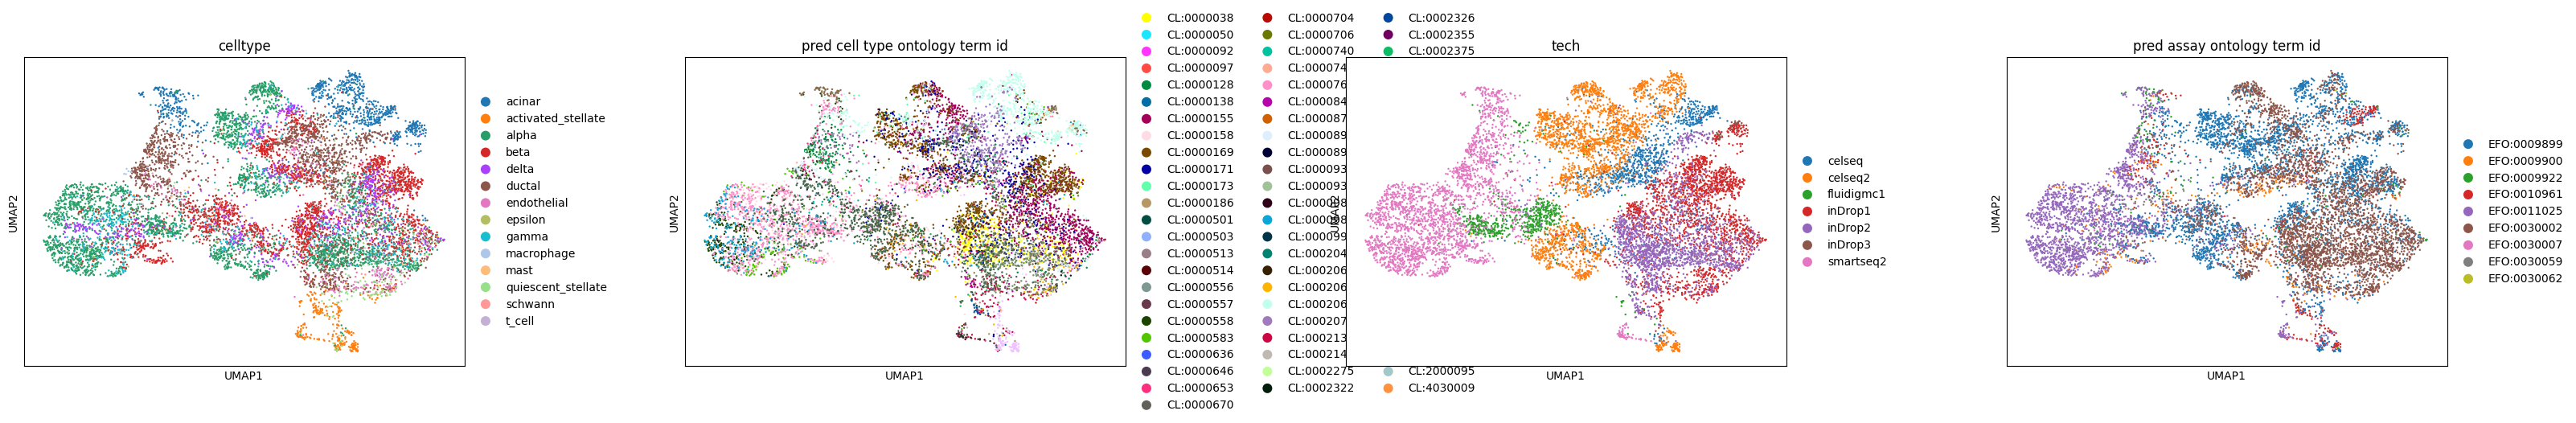

In [24]:
sc.pl.scatter(subadata, basis="umap", color=["celltype", "pred_cell_type_ontology_term_id", "tech", "pred_assay_ontology_term_id"])

In [ ]:
sc.pl.scatter(subadata, basis="umap", color=["celltype", "pred_cell_type_ontology_term_id", "tech"])

In [87]:
bm = Benchmarker(
    subadata,
    batch_key="tech",
    label_key="celltype",
    embedding_obsm_keys=["Unintegrated", "scprint"],
    n_jobs=6,
)
bm.benchmark()

Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]2024-02-20 17:44:05,392:INFO - isolated labels: no more than 2 batches per label
2024-02-20 17:44:05,454:INFO - Unable to initialize backend 'cuda': 
2024-02-20 17:44:05,455:INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-02-20 17:44:05,463:INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2024-02-20 17:44:05,465:WARNING - An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.

Metrics:  10%|█         | 1/10 [00:07<01:06,  7.42s/it, Bio conservation: nmi_ari_cluster_labels_kmeans]


Metrics:  60%|██████    | 6/10 [00:34<00:18,  4.63s/it, Batch correction: kbet_per_label]

INFO     t_cell consists of a single batch or is too small. Skip.                                                  



Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]2024-02-20 17:44:51,072:INFO - isolated labels: no more than 2 batches per label

Metrics:  60%|██████    | 6/10 [00:38<00:16,  4.22s/it, Batch correction: kbet_per_label]

INFO     t_cell consists of a single batch or is too small. Skip.                                                  



Metrics:  80%|████████  | 8/10 [00:50<00:13,  6.61s/it, Batch correction: pcr_comparison]    /home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(

Embeddings: 100%|██████ | 9/10 [00:50<00:03,  3.58s/it, Batch correction: pcr_comparison]██████████| 2/2 [01:36<00:00, 48.74s/it]██████████| 2/2 [01:36<00:00, 48.28s/it]

                                                                                         

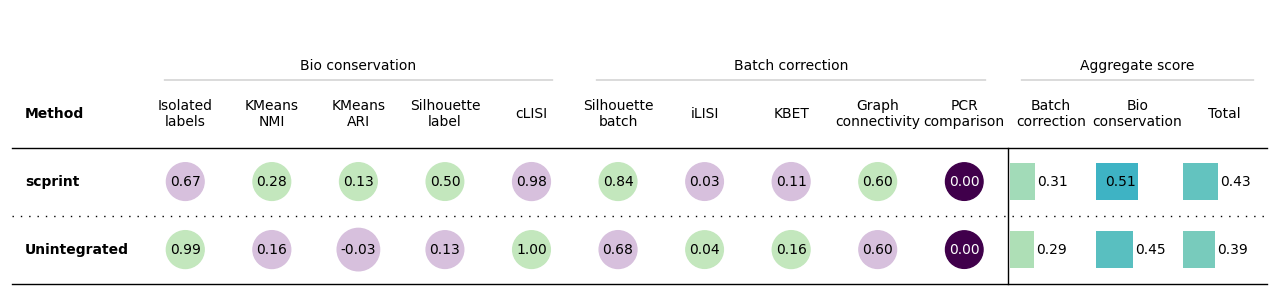

In [88]:
bm.plot_results_table(min_max_scale=False)

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


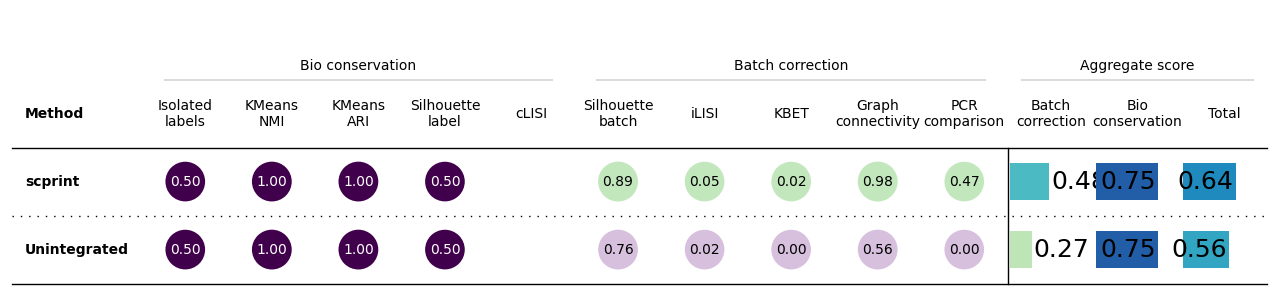

In [180]:
bm.plot_results_table(min_max_scale=False)

In [ ]:
adata.X.iloc[0].to_array()

In [ ]:
model

## results from running it on most famous methods

![](https://scib-metrics.readthedocs.io/en/stable/_images/72fe472fdb279e95aba93bd88bf06ad186ff74cc30d6ec63c47b0025da83ccc0.png)

In [ ]:
## load a random dataset

In [ ]:
## do scGPT finetuning task (reusing the helper functions I have) and the notebook that they provide

In [ ]:
## create a task/function for scPrint

In [ ]:
## try to do an embedding from the regulon / single cell type matrix outputted by scenic

In [ ]:
## push it to a function on BenGRN